In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np

In [2]:
from catalyst import cond, measure, for_loop, qjit
import jax; jax.config.update('jax_platform_name', 'cpu')
from jax import numpy as jnp
from jax import random

In [62]:
def measure_and_reset(wire):
    """
    Measure a wire and then reset it back to the |0⟩ state.
    """

    m = measure(wire)

    @cond(m)
    def conditional_flip():
        qml.PauliX(wires=wire)

    conditional_flip()

    return m
    
def conditional_unitary(pred, wire):
    """Conditionally perform unitary operation based on a predicate"""
    
    @cond(pred)
    def conditional_unitary():
        qml.PauliX(wires=wire)
    
    conditional_unitary()
    
def conditional_update(x_max, m1):
    
    @cond(x_max < 0)
    def conditional_fn():
        # when the predicate is true
        return (m1 == 0).astype(int), (m1 == 1).astype(int), (m1 != 5).astype(int), (m1 != 5).astype(int)

    @conditional_fn.otherwise
    def conditional_fn():
        return (m1 == 5).astype(int), (m1 == 5).astype(int), (m1 == 5).astype(int), (m1 == 5).astype(int)
    
    return conditional_fn()  # must invoke the defined function

def ham_z(t):
    qml.PauliRot(2*t, 'ZY',  wires=[0,1])

In [113]:
dev = qml.device("lightning.qubit", wires=2)

@qjit
@qml.qnode(dev)
def circuit(k0: int, k1: int, t: float, max_iter, meas, k0_hist, k1_hist, x_max_hist):

    def loop(i, x, kk0, kk1, meas, kk0_hist, kk1_hist, x_max_hist):
        qml.Hadamard(1)
        ham_z(x)
        m1 = 0 + measure_and_reset(1)
        
        a = m1 == 0
        b = m1 == 1
       
        temp_k0 = kk0 + a
        temp_k1 = kk1 + b
        val_0 = (temp_k1 - temp_k0)/(temp_k0 + temp_k1)
        x_max_0 = 0.5*jnp.arcsin(val_0)
        
        c0, c1, b0, b1 = conditional_update(x_max_0, m1)
        
        kk0 = b0*kk0 + c0
        kk1 = b1*kk1 + c1
        val_1 = (kk1 - kk0)/(kk0 + kk1 + 0.1)
        x_max_1 = 0.5*jnp.arcsin(val_1)
                
        syndrome = x_max_1 >=0
        conditional_unitary(syndrome, wire=0)
        
        max_iter = 100
        additions = jnp.identity(max_iter)*m1
        meas = meas + additions[i]
        
        additions = jnp.identity(max_iter)*kk0
        kk0_hist = kk0_hist + additions[i]
        
        additions = jnp.identity(max_iter)*kk1
        kk1_hist = kk1_hist + additions[i]
        
        additions = jnp.identity(max_iter)*x_max_0
        x_max_hist = x_max_hist + additions[i]
        
        return x, kk0, kk1, meas, kk0_hist, kk1_hist, x_max_hist

    # apply the while loop
    final_x = for_loop(0, max_iter, 1)(loop)(t, k0, k1, meas, k0_hist, k1_hist, x_max_hist)

    return qml.state(), final_x

max_iter = 100
epsilon = 0.02

# intermediate values
meas = np.zeros(max_iter)
k0_hist = np.zeros(max_iter)
k1_hist = np.zeros(max_iter)
x_max_hist = np.zeros(max_iter)

res = circuit(0, 0, epsilon, max_iter, meas, k0_hist, k1_hist, x_max_hist)
state = res[0]
meas, k0_hist, k1_hist, x_max_hist = res[4:]

state = np.round(state,2)
print('state real:', state.real)
print('state imag:', state.imag)

state real: [0. 0. 1. 0.]
state imag: [0. 0. 0. 0.]


In [114]:
num_ones = int(np.sum(meas))
num_zeros = max_iter - num_ones
print("Number of ones:", num_ones)
print("Number of zeros:", num_zeros)

Number of ones: 41
Number of zeros: 59


Text(0.5, 1.0, 'k0, k1 vs iterations')

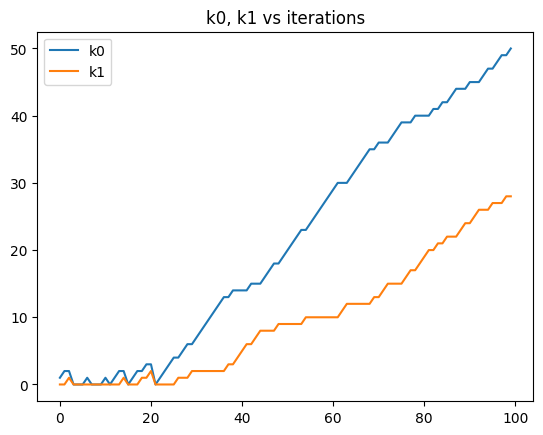

In [123]:
plt.plot(k0_hist)
plt.plot(k1_hist)
plt.legend(['k0', 'k1'])
plt.title("k0, k1 vs iterations")

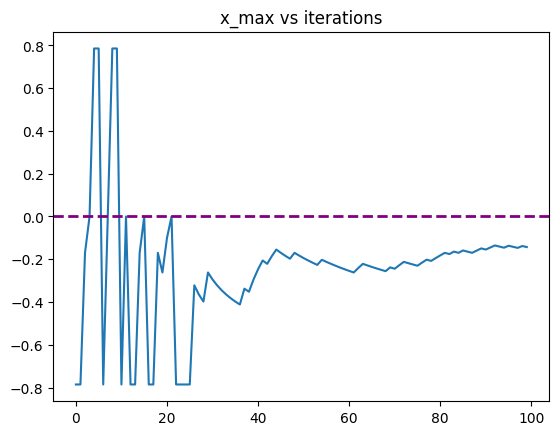

In [122]:
plt.plot(x_max_hist)
plt.axhline(y=0.0, color="purple", ls="--", lw=2, label=f"Eth: {0.0}")
plt.title("x_max vs iterations");

In [336]:
# values = [0, 0]
# n = 100
# for i in range(n):
#     basis_states, counts, x, k0, k1 = circuit(0, 0, 0.02)
#     fill = int(np.log2(len(basis_states)))
#     res = {bin(int(state))[2:].zfill(fill): count for state, count in zip(basis_states, counts)}
#     values[0] += res['0']
#     values[1] += res['1']

# values[0] /= n*100
# values[1] /= n*100

In [8]:
values

[Array(0.4, dtype=float64), Array(0.6, dtype=float64)]

<BarContainer object of 2 artists>

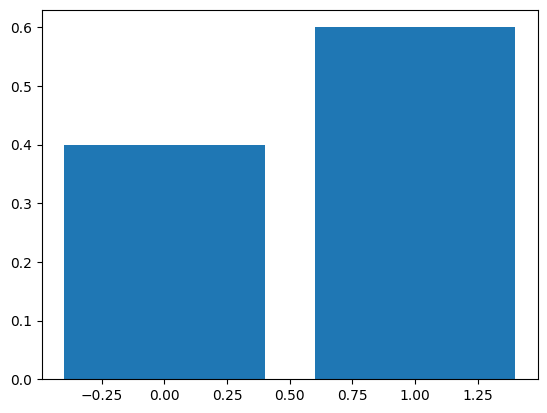

In [9]:
plt.bar(height= values, x = [0,1])

In [649]:
dev = qml.device("lightning.qubit", wires=2, shots=100)

@qjit
@qml.qnode(dev)
def circuit(k0: int, k1: int, t: float):

    def loop(i, x, kk0, kk1):
        qml.Hadamard(1)
        
        return x, kk0, kk1

    # apply the while loop
    final_x = for_loop(0, 1, 1)(loop)(t, k0, k1)

    return qml.counts(), final_x

basis_states, counts, x, k0, k1 = circuit(0, 0, 0.01)
fill = int(np.log2(len(basis_states)))
res = {bin(int(state))[2:].zfill(fill): count for state, count in zip(basis_states, counts)}
res

{'00': Array(50, dtype=int64),
 '01': Array(0, dtype=int64),
 '10': Array(50, dtype=int64),
 '11': Array(0, dtype=int64)}